### Apply weights to ET & SW observations, make ajustments as necessary, save output for pyemu

In [1]:
# 8/20/2020
# M Nielsen

In [4]:
import os
import numpy as np
import pandas as pd

Start with ET observations, then process SW observations.  Save files to use with pyemu.

In [5]:
#Set locations:
OBSDIR = 'E:\\UMID_Data\\0188_offline\\modeldev\\OBS'

In [6]:
# ET observations first:

etobs = pd.read_csv(os.path.join(OBSDIR,'OBSERVATIONS_DATA_ET_wVARIANCES.csv'))

etobs.drop(etobs.columns[0], axis=1, inplace=True)
etobs.drop(etobs.columns[1], axis=1, inplace=True)
del etobs['month']

# Make names lowercase to match pyemu:
etobs['ObsName'] = etobs['ObsName'].str.lower()
etobs['ObsGroup'] = etobs['ObsGroup'].str.lower()
print (etobs.info())
print (etobs.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4914 entries, 0 to 4913
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ObsName   4914 non-null   object 
 1   LU        4914 non-null   object 
 2   Value     4842 non-null   float64
 3   year      4914 non-null   int64  
 4   YR        4914 non-null   int64  
 5   ObsGroup  4914 non-null   object 
 6   variance  4914 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 268.9+ KB
None
              ObsName   LU  Value  year  YR   ObsGroup  variance
0  aetdcd-001_2013_01  DCD   0.45  2013  13  aet-dcd13  0.136330
1  aetdcd-001_2013_02  DCD   0.33  2013  13  aet-dcd13  0.226211
2  aetdcd-001_2013_03  DCD   2.43  2013  13  aet-dcd13  0.547783
3  aetdcd-001_2013_04  DCD   3.55  2013  13  aet-dcd13  0.280142
4  aetdcd-001_2013_05  DCD   4.71  2013  13  aet-dcd13  0.118134
5  aetdcd-001_2013_06  DCD   6.02  2013  13  aet-dcd13  0.126475
6  aetdcd-001_2013_

In [7]:
# Calculate weights from the variances:
etobs['WEIGHT'] = 1 / etobs['variance']

del etobs['year']
del etobs['LU']
del etobs['YR']

In [8]:
print (etobs.tail())
print (etobs.ObsGroup.unique())

                 ObsName  Value ObsGroup  variance    WEIGHT
4909  aets15-581_2015_05   5.64  aet-s15  0.485879  2.058127
4910  aets15-581_2015_06   6.06  aet-s15  0.300687  3.325716
4911  aets15-581_2015_07   6.75  aet-s15  0.172212  5.806810
4912  aets15-581_2015_08   5.61  aet-s15  0.512773  1.950179
4913  aets15-581_2015_09   3.65  aet-s15  0.300227  3.330809
['aet-dcd13' 'aet-dcd14' 'aet-dcd15' 'aet-evr13' 'aet-evr14' 'aet-evr15'
 'aet-wet13' 'aet-wet14' 'aet-wet15' 'aet-c13' 'aet-c14' 'aet-c15'
 'aet-r13' 'aet-r14' 'aet-r15' 'aet-s13' 'aet-s14' 'aet-s15']


In [9]:
# Reduce the number of obs groups for the ET:
etobs['OBS_group'] = etobs['ObsGroup'].str[:-2]
etobs.loc[etobs['OBS_group'] == 'aet-c', 'OBS_group'] = 'aet-corn'
etobs.loc[etobs['OBS_group'] == 'aet-r', 'OBS_group'] = 'aet-rice'
etobs.loc[etobs['OBS_group'] == 'aet-s', 'OBS_group'] = 'aet-soy'

print (etobs.OBS_group.unique())

['aet-dcd' 'aet-evr' 'aet-wet' 'aet-corn' 'aet-rice' 'aet-soy']


In [10]:
etobs.head()

,ObsName,Value,ObsGroup,variance,WEIGHT,OBS_group
0,aetdcd-001_2013_01,0.45,aet-dcd13,0.136330,7.335136,aet-dcd
1,aetdcd-001_2013_02,0.33,aet-dcd13,0.226211,4.420646,aet-dcd
2,aetdcd-001_2013_03,2.43,aet-dcd13,0.547783,1.825542,aet-dcd
3,aetdcd-001_2013_04,3.55,aet-dcd13,0.280142,3.569624,aet-dcd
4,aetdcd-001_2013_05,4.71,aet-dcd13,0.118134,8.464989,aet-dcd


In [11]:
# Next, the SW observations:
swobs = pd.read_csv(os.path.join(OBSDIR,'OBSERVATIONS_DATA_BF_RO_wVARIANCES.csv'))
swobs.rename(columns = {'IDX2':'ObsName',
                       'OBSVAL':'Value',
                       'Variance':'variance'}, inplace=True)
del swobs['Unnamed: 0']
print (swobs.head())
print (swobs.OBS_group.unique())

                ObsName                              Comment      Value  \
0  bf_10_7030392_yr2000  Used original val, no upstream site   7.572857   
1  bf_10_7030392_yr2001  Used original val, no upstream site   9.458571   
2  bf_10_7030392_yr2002  Used original val, no upstream site  14.927143   
3  bf_10_7030392_yr2003  Used original val, no upstream site  13.767143   
4  bf_10_7030392_yr2004  Used original val, no upstream site  14.840000   

   OBS_group  variance  
0  BF_annual  0.058524  
1  BF_annual  1.876748  
2  BF_annual  2.069557  
3  BF_annual  1.036057  
4  BF_annual  1.301733  
['BF_annual' 'RO_annual' 'BF_monthly' 'RO_monthly']


For SW, weights based on the watershed size and type of observation, not the variance of the observation.

Using the range of the ET weights as a target, came up with a method to 
weight the SW observations, based on the size of the watershed.  The "base" weight is the natural log of the watershed size subtracted from the MAX of all the natural logs of the watershed sizes.  This gives a range in weights from about 0.25 for the ones about 1000 mi2, to 3.7 for the smallest, about 31 mi2.  Then for the "higher weight" observations, i.e. ones in which we're more confident in the observed values because of the method used (baseflow separation) - use this value * 1.5.  And for the "lower weight" obs, for which the method is not so great (i.e. monthly baseflow values - because of lag in recharge to baseflow), divide the "base" weight by 2. 

In [12]:
swobs['station'] = swobs['ObsName'].str.split('_').str[2].astype(int)

In [17]:
# get weights data:
infile = os.path.join(OBSDIR, 'Baseflow_Separation_Results\Sites with baseflow data done.xlsx')
tmp = pd.read_excel(infile, 'Weighting')
wtdata = tmp[['stationid','BASE Weight','Lower weight','Higher weight']]
wtdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   stationid      60 non-null     int64  
 1   BASE Weight    60 non-null     float64
 2   Lower weight   60 non-null     float64
 3   Higher weight  60 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.0 KB


In [18]:
# Join the weights into the swobs:
swobs2 = pd.merge(swobs, wtdata, how='left', left_on='station', right_on='stationid')
swobs2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26824 entries, 0 to 26823
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ObsName        26824 non-null  object 
 1   Comment        26824 non-null  object 
 2   Value          26824 non-null  float64
 3   OBS_group      26824 non-null  object 
 4   variance       26824 non-null  float64
 5   station        26824 non-null  int32  
 6   stationid      26824 non-null  int64  
 7   BASE Weight    26824 non-null  float64
 8   Lower weight   26824 non-null  float64
 9   Higher weight  26824 non-null  float64
dtypes: float64(5), int32(1), int64(1), object(3)
memory usage: 2.1+ MB


In [19]:
swobs2.tail()

,ObsName,Comment,Value,OBS_group,variance,station,stationid,BASE Weight,Lower weight,Higher weight
26819,ro_9_7027720_sep-15,"Used original val, no upstream site.",0.064286,RO_monthly,0.000062,7027720,7027720,1.562218,0.781109,2.343327
26820,ro_9_7027720_sep-16,"Used original val, no upstream site.",0.031429,RO_monthly,0.000081,7027720,7027720,1.562218,0.781109,2.343327
26821,ro_9_7027720_sep-17,"Used original val, no upstream site.",1.312857,RO_monthly,0.127924,7027720,7027720,1.562218,0.781109,2.343327
26822,ro_9_7027720_sep-18,"Used original val, no upstream site.",1.635714,RO_monthly,0.046495,7027720,7027720,1.562218,0.781109,2.343327
26823,ro_9_7027720_sep-19,"Used original val, no upstream site.",0.024286,RO_monthly,0.000029,7027720,7027720,1.562218,0.781109,2.343327


In [20]:
swobs2.Comment.unique()

array(['Used original val, no upstream site',
       'Incremental inches calculated',
       'More runoff upstream than at gage, increment calculated',
       'Used original val, no upstream site.'], dtype=object)

In [21]:
# Assign actual weights:
swobs2['WEIGHT'] = swobs2['BASE Weight']
swobs2.loc[swobs2['OBS_group'] == 'RO_monthly', 'WEIGHT'] = swobs2['Higher weight']
swobs2.loc[swobs2['OBS_group'] == 'BF_annual', 'WEIGHT'] = swobs2['Higher weight']
swobs2.loc[swobs2['OBS_group'] == 'BF_monthly', 'WEIGHT'] = swobs2['Lower weight']

In [22]:
# Subset for joining with ET:
swobs3 = swobs2[['ObsName','Value','OBS_group','variance','WEIGHT']]

#### Join two sets together, save file for pyemu

In [23]:
# Re-order ET observations and join:
etobs2 = etobs[['ObsName','Value','OBS_group','variance','WEIGHT']]

In [25]:
allobs = etobs2.append(swobs3)
allobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31738 entries, 0 to 26823
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ObsName    31738 non-null  object 
 1   Value      31666 non-null  float64
 2   OBS_group  31738 non-null  object 
 3   variance   31738 non-null  float64
 4   WEIGHT     31738 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.5+ MB


In [26]:
allobs.to_csv(os.path.join(OBSDIR, 'ALLOBS.INFO.for.pyemu.csv'))

### Investigating weights a little:

In [28]:
tmp = allobs.groupby('OBS_group').describe().unstack(1).reset_index()
tmp2 = tmp.loc[tmp['level_0'] == 'Value']
weights = tmp.loc[tmp['level_0'] == 'WEIGHT']

In [29]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   level_0    240 non-null    object 
 1   level_1    240 non-null    object 
 2   OBS_group  240 non-null    object 
 3   0          240 non-null    float64
dtypes: float64(1), object(3)
memory usage: 7.6+ KB


In [30]:
weights.pivot(index='OBS_group',columns='level_1',values=0)

level_1,25%,50%,75%,count,max,mean,min,std
OBS_group,,,,,,,,
BF_annual,1.622089,2.343327,3.432541,990.0,6.877255,2.602450,0.183762,1.411297
BF_monthly,0.540696,0.781109,1.144181,12584.0,2.292418,0.867073,0.061254,0.468293
RO_annual,1.062626,1.562218,2.294899,980.0,4.584837,1.733820,0.122508,0.945293
RO_monthly,1.622089,2.343327,3.471774,12270.0,6.877255,2.605089,0.183762,1.411269
aet-corn,2.440897,3.377105,5.399295,306.0,11.078882,4.064803,0.954397,2.307782
aet-dcd,3.545329,5.162472,7.816026,1152.0,8.698054,5.524339,1.825542,2.321665
aet-evr,4.502075,6.603528,8.233104,900.0,10.314655,6.558868,2.866677,2.370642
aet-rice,2.440472,3.761897,5.329073,252.0,9.748316,4.177104,1.190213,2.160950
aet-soy,2.058127,3.583993,5.201213,396.0,5.968249,3.572291,1.083911,1.619684


In [31]:
import matplotlib.pyplot as plt

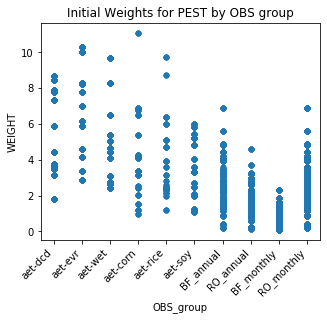

In [34]:
fig = plt.figure(figsize=(5, 4))
figname = 'Initial weights for PEST obs.png'
ax1 = fig.add_subplot(1,1,1)

allobs.plot.scatter('OBS_group','WEIGHT', ax=ax1)

ax1.set_title('Initial Weights for PEST by OBS group')

plt.setp( ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

fig.savefig(figname, dpi = (250), bbox_inches='tight')